In [6]:
import time
import os
from ipywidgets import interact
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from numba import njit, jit


# Chirp data generate
n=2000 # number of samples to use for the chirp
fs=20000 # The sampling rate for the chrip
f0=100# the start frequency in Hz for the chirp
f1=1000 # the stop frequency of the chirp
t1=n/fs # the total length of the chirp in s
f_disturber_hz=2000

disturber_amplitude=0.3
chirp_disturber_full_amp=0.6

t = np.linspace(0, t1, n)

y_signal = signal.chirp(t, f0=f0, f1=f1, t1=t1, method='linear')
y_signal = (chirp_disturber_full_amp-disturber_amplitude)*y_signal#*(2**(15-1))

# Add some a disturber to the chirp
y_disturber_sine = np.sin(2*np.pi*f_disturber_hz*t)
y_disturber_sine = y_disturber_sine * disturber_amplitude #* (2**(15-1))
y_signal_disturber_sine = y_signal + y_disturber_sine

y_disturber_noise = np.random.normal(0, 0.2, n)
y_disturber_noise = y_disturber_noise * disturber_amplitude #* (2**(15-1))
y_signal_disturber_noise = y_signal + y_disturber_noise

#pos_shift_disturber=16
#pos_shift_signal=32
#y_disturber = np.append([0]* pos_shift_disturber, y_disturber[:-1*pos_shift_disturber])
#y_signal_disturber = np.append([0]* shift_signal, y_signal_disturber[:-1*shift_signal])

def load_wav(filename):
    y, fs = sf.read(filename, dtype='float32')
    return fs, y.T

interactive(children=(Dropdown(description='data_sel', options=('chirp_sine', 'chirp_noise', '1kHz_peak_1g_ext…

<function __main__.update(data_sel, num_coeff=128, mu=0.01, adaption_step=1)>

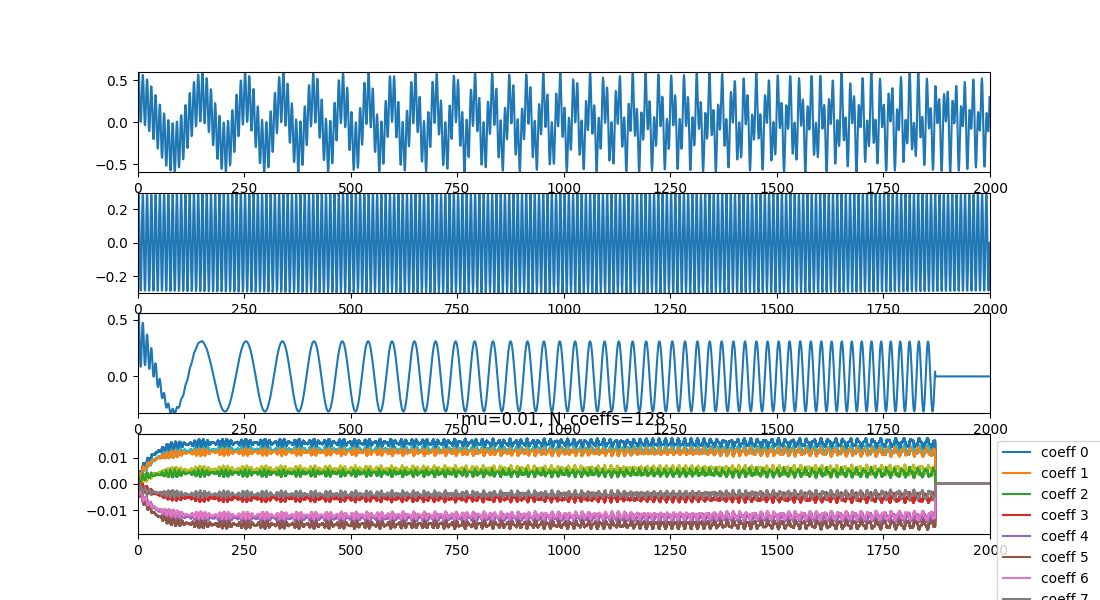

In [7]:
%matplotlib widget

@njit
def lms_fir(data, ref_noise, N_coeffs, mu, scale_bits=31, adaption_step = 1, fix_point=False):
    coeffs_matrix = np.zeros((len(data), N_coeffs), dtype=np.float32)
    out=np.zeros(data.shape[0], dtype=np.float32)
    coeffs = np.zeros(N_coeffs, dtype=np.float32)
    tap_buffer = np.zeros(N_coeffs, dtype=np.float32)
    
    # Interate over the data
    for j in range(0, len(data) - len(coeffs)): 
        
        acc=0
        #iterate over the coefficients to calculate the filter and get the canceller
        for i in range(N_coeffs):
            noise=ref_noise[j+i]
            tap_buffer[i] = noise
            acc+=coeffs[i] * noise

        #if fix_point:
        #    acc=acc>>scale_bits

        # Calculate the output signal
        out[j] = data[j]-acc

        #calculate the coefficient adaptation
        #if fix_point:
            #prod = (mu*out[j]) >> scale_bits
        #else:
        prod = mu*out[j]

        if (j % adaption_step) == 0:
            for i in range(N_coeffs):
                # if fix_point:
                #     coeffs[i] += (prod*tap_buffer[i]) >> scale_bits 
                #else:
                coeffs[i] += prod*tap_buffer[i]
        # Store the coefficients       
        coeffs_matrix[j, :] = coeffs[:]
    return out, coeffs_matrix


# load the wav files names
wav_folder_path = "./lpdsp32/cSensorSignalProcessing/test/testdata/input"
# Get a list of all files in the folder
file_names = [f for f in os.listdir(wav_folder_path) if f.endswith(".wav")]
data_sel=['chirp_sine', 'chirp_noise'] + file_names

# setup the plot
cols = 1
rows = 4
fig=plt.figure(figsize=(11, 6))
plot1 = plt.subplot2grid( (rows, cols), (0,0), 1)
line1 = plot1.plot([0], label="Chirp with noise")
plot2 = plt.subplot2grid((rows,cols),(1,0), sharex=plot1)
line2 = plot2.plot([0], label="noise")
plot3 = plt.subplot2grid((rows, cols), (2,0), sharex=plot1)
line3 = plot3.plot([0], label="output")
plot4 = plt.subplot2grid((rows, cols), (3,0), sharex=plot1)
line4 = plot4.plot([0], label="filter coefficients")


def update(
        data_sel, num_coeff = 128, mu=0.01, 
        #fix_point=False, scale_bits=31, 
        adaption_step=1
        ):
    start0 = time.time()
    global y_signal_disturber, y_disturber

    # if fix_point:
    #     y_s_d = (y_signal_disturber * (2**(scale_bits))).astype(int).tolist()
    #     y_d = (y_disturber * (2**(scale_bits))).astype(int).tolist()
    #     mu = int(mu * (2**(scale_bits)))
    # else:
    if data_sel == "chirp_sine":
        y_s_d = y_signal_disturber_sine.astype(np.float32)
        y_d = y_disturber_sine.astype(np.float32)
    elif data_sel == "chirp_noise":
        y_s_d = y_signal_disturber_noise.astype(np.float32)
        y_d = y_disturber_noise.astype(np.float32)
    else:
        fs, data = load_wav(f"{wav_folder_path}/{data_sel}")
        y_s_d = data[1]
        y_d = data[0]

    # plot the chirp with noise
    line1[0].set_data(range(len(y_s_d)), y_s_d)
    plot1.set_xlim(0, len(y_s_d))
    plot1.set_ylim(min(y_s_d), max(y_s_d))

    # Plot the noise
    data = y_d
    line2[0].set_data(range(len(data)), data)
    plot2.set_xlim(0, len(data))
    plot2.set_ylim(min(data), max(data))

    #Plot the result
    start1 = time.time()
    data, coeffs_matrix = lms_fir(y_s_d, y_d, num_coeff, mu, 
                                  #scale_bits=scale_bits, fix_point=fix_point
                                  adaption_step=adaption_step, 
                                  )
    end1 = time.time()
    print("Elapsed (for fir_lms) = %s" % round(end1 - start1, 3))
    line3[0].set_data(range(len(data)), data)
    plot3.set_xlim(0, len(data))
    plot3.set_ylim(np.min(data), np.max(data))

    #plot the coefficients progress
    plot4.clear()
    plot4.set_title(f"mu={round(mu,4)}, N_coeffs={num_coeff}")
    for i in range(coeffs_matrix.shape[1]):
        data = coeffs_matrix[:, i]
        plot4.plot(range(data.size), data, label="coeff {}".format(i))
    plot4.set_xlim(0, data.size)
    plot4.autoscale(axis='y')
    plot4.legend(bbox_to_anchor=(1,1), loc="upper left")
    fig.canvas.draw_idle()
    #plt.tight_layout()
    end0 = time.time()
    print("Elapsed (for update function) = %s" % round(end0 - start0, 3))

interact(update, data_sel=data_sel ,num_coeff=(0, 256, 2), mu=(0.001, 0.1, 0.001), 
         #fix_point=False, scale_bits=(1, 31, 1), 
         adaption_step=(1 , 128 ,1)
         )
